In [1]:
import numpy as np
import time
from datetime import datetime, timedelta
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
from shapely.geometry import Polygon, Point
from sliderule import sliderule
from sliderule import icesat2
from pyproj import Transformer, CRS
import requests


In [2]:
url="icesat2sliderule.org"
icesat2.init(url, verbose=False)

## Intro
This notebook demonstrates how to use the SlideRule Icesat-2 API to retrieve ATL03 data with two different classifications, one based on the external ATL08-product classifications, designed to distinguish between vegetation and ground returns, and the other based on the experimental YAPC (Yet Another Photon Class) algorithm.

### Define a function to retrieve ATL03 data

In [3]:
def ATL03_data_for_granule(granule, pair, poly, params=None, epsg=3857, asset="nsidc-s3", beam='strong'):
    if params is None:
        params={'poly':poly, 'srt':0, 'cnf':0}
    else:
        params.update({'poly':poly})
    
    gdf = gpd.GeoDataFrame(icesat2.atl03s(params, granule.replace('ATL06','ATL03'), track=int(pair), asset=asset))
    crs=CRS.from_epsg(epsg)
    to_xy_crs=Transformer.from_crs(crs.geodetic_crs, crs)
    x, y, z = to_xy_crs.transform(gdf['geometry'].y.values, gdf['geometry'].x.values, gdf['height'])
    gdf['x'] = x
    gdf['y'] = y
    gdf['height'] = z
    
    #tested on cycle 11, where the strong beam in the pair matches the spacecraft orientation.  Need to check 
    # on other cycles
    if beam=='strong':
        gdf=gdf[gdf['sc_orient'] == gdf['pair']]
    elif beam=='weak':
        gdf=gdf[gdf['sc_orient'] != gdf['pair']]
    # otherwise, return both beams
    return gdf


In [4]:
project_srs="26912+5703"

### Retrieve ATL03 elevations with ATL08 classifications

define a polygon to encompass Grand Mesa, and pick an ATL03 granule that has good coverage over the top of the mesa.  Note that this granule was captured at night, under clear-sky conditions.  Other granules are unlikely to have results as clear s these.

In [5]:
granule, pair, poly=['ATL03_20191114034331_07370502_004_01.h5',1,
 [{'lat': 39.34603060272382, 'lon': -108.40601489205419},
  {'lat': 39.32770853617356, 'lon': -107.68485163209928},
  {'lat': 38.770676045922684, 'lon': -107.71081820956682},
  {'lat': 38.788639821001155, 'lon': -108.42635020791396},
  {'lat': 39.34603060272382, 'lon': -108.40601489205419}]]

params_08= {'atl08_class':[ 'atl08_noise', 'atl08_ground', 'atl08_canopy', 'atl08_top_of_canopy', 'atl08_unclassified'], 
        'len':20, 'pass_invalid':True}

D3=ATL03_data_for_granule(granule, pair, poly, params_08, epsg=project_srs, asset="nsidc-s3", beam='strong')


### Plot the ATL08 classifications

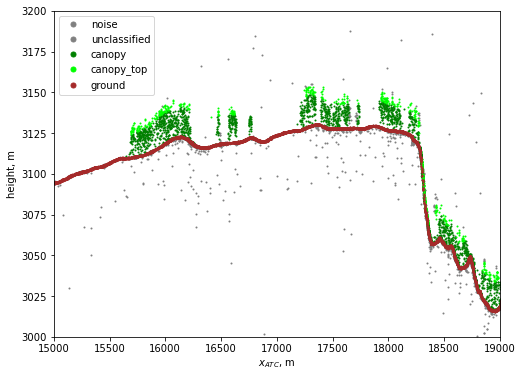

In [6]:
plt.figure(figsize=[8,6])

colors={0:['gray', 'noise'], 
        4:['gray','unclassified'],  
        2:['green','canopy'], 
        3:['lime', 'canopy_top'], 
        1:['brown', 'ground']}
d0=np.min(D3['segment_dist'])
for class_val, color_name in colors.items():
    ii=D3['atl08_class']==class_val
    plt.plot(D3['segment_dist'][ii]+D3['distance'][ii]-d0, D3['height'][ii],'o', 
             markersize=1, color=color_name[0], label=color_name[1])
hl=plt.legend(markerscale=5)
plt.gca().set_xlim([15000, 19000])
plt.gca().set_ylim([3000, 3200])

plt.ylabel('height, m')
plt.xlabel('$x_{ATC}$, m');




### Repeat using YAPC classifications


In [7]:

params_yapc= { 'yapc':dict(knn=0, win_h=6, win_x=11, min_ph=4), 'pass_invalid':True}

D3y=ATL03_data_for_granule(granule, pair, poly, params_yapc, epsg=project_srs, asset="nsidc-s3", beam='strong')


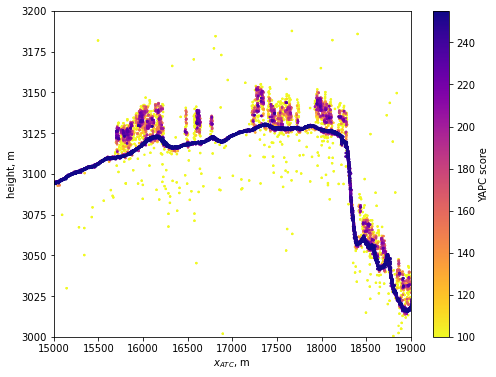

In [8]:
plt.figure(figsize=[8,6])

d0=np.min(D3y['segment_dist'])
ii=np.argsort(D3y['yapc_score'])
plt.scatter(D3y['segment_dist'][ii]+D3y['distance'][ii]-d0, D3y['height'][ii],2, c=D3y['yapc_score'][ii], vmin=100, vmax=255, cmap='plasma_r')
plt.colorbar(label='YAPC score')
plt.gca().set_xlim([15000, 19000])
plt.gca().set_ylim([3000, 3200])

plt.ylabel('height, m')
plt.xlabel('$x_{ATC}$, m');


